In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Conv1D, Add, Flatten, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:

# Load the data
df = pd.read_csv(r'C:\Users\ASUS\Documents\Zalo Received Files\DaNang.csv')
print(df.columns)

# Preprocess the data
df['date'] = pd.to_datetime(df['date'], dayfirst=True)  # Chuyển đổi cột date thành định dạng thời gian
df.set_index('date', inplace=True)  # Đặt cột date làm index


# Check for null values and drop them
null_count = df.isnull().sum()
print(null_count)
df = df.dropna()

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['AQI']])

# Prepare data function
def prepare_data(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

timesteps = 30  # Độ dài của cửa sổ trượt
X, y = prepare_data(scaled_data, timesteps)




Index(['Index', 'date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI'], dtype='object')
Index    0
pm25     0
pm10     0
o3       0
no2      0
so2      0
co       0
AQI      0
dtype: int64


In [3]:

# Build the model
input_layer = Input(shape=(timesteps, 1))
x = LSTM(64, return_sequences=True)(input_layer)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = Conv1D(64, kernel_size=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(1, kernel_size=3, padding='same')(x)
x = Add()([x, input_layer])
output_layer = Activation('tanh')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 30, 64)            │          16,896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 30, 64)            │          12,352 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 30, 64)            │           8,256 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 30, 64)            │             256 │ conv1d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 30, 64)            │           4,160 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 30, 64)            │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 30, 64)            │          12,352 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 30, 64)            │             256 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 30, 1)             │             193 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 30, 1)             │               0 │ conv1d_4[0][0],            │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 30, 1)             │               0 │ add[0][0]                  │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 54,977 (214.75 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [4]:
def predict_future(model, data, time_step, future_days, scaler):
    temp_input = data[-time_step:].reshape(1, time_step, 1)
    future_output = []

    for _ in range(future_days):
        prediction = model.predict(temp_input, verbose=0)
        future_output.append(prediction[0][0])
        temp_input = np.roll(temp_input, -1)  # Dịch chuyển các phần tử sang trái 1 vị trí
        temp_input[-1][-1] = prediction[0][0]  # Gán giá trị dự đoán vào vị trí cuối cùng của temp_input

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output


def custom_round(number):
    if number >= 0:
        return int(number + 0.5)  # Làm tròn lên
    else:
        return int(number - 0.5)  # Làm tròn xuống

[[0.16427105]
 [0.06160164]
 [0.0862423 ]
 ...
 [0.05544148]
 [0.05544148]
 [0.05544148]]
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1307 - mae: 0.2569 - val_loss: 0.1324 - val_mae: 0.3350
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0159 - mae: 0.0866 - val_loss: 0.2016 - val_mae: 0.4250
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - mae: 0.0721 - val_loss: 0.1940 - val_mae: 0.4156
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - mae: 0.0667 - val_loss: 0.1782 - val_mae: 0.3955
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0138 - mae: 0.0774 - val_loss: 0.1278 - val_mae: 0.3244
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - mae: 0.0656 - val_loss: 0.0848 - val_mae: 0.2405
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0095 - mae: 0.0655 - val_loss: 0.0690 - val_mae: 0.2081
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0089 - mae: 0.0609 - val_loss: 0.0

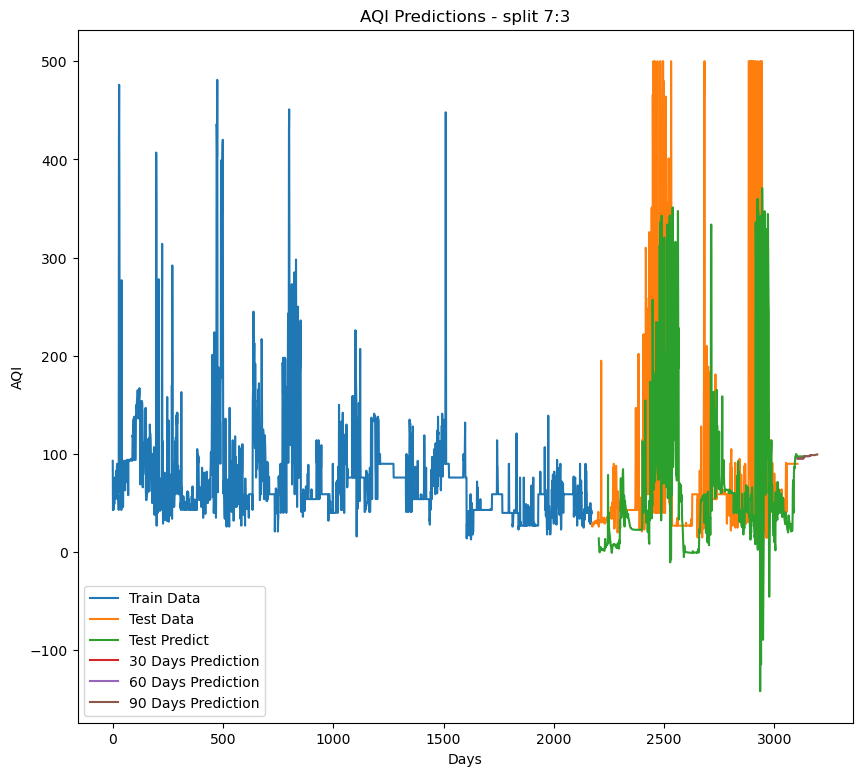

[[0.16427105]
 [0.06160164]
 [0.0862423 ]
 ...
 [0.25462012]
 [1.        ]
 [1.        ]]
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - mae: 0.0570 - val_loss: 0.0582 - val_mae: 0.1361
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - mae: 0.0637 - val_loss: 0.0525 - val_mae: 0.1243
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0121 - mae: 0.0660 - val_loss: 0.0583 - val_mae: 0.1244
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0127 - mae: 0.0656 - val_loss: 0.0789 - val_mae: 0.1400
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - mae: 0.0609 - val_loss: 0.0626 - val_mae: 0.1201
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - mae: 0.0612 - val_loss: 0.0652 - val_mae: 0.1322
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mae: 0.0546 - val_loss: 0.0522 - val_mae: 0.1240
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0120 - mae: 0.0611 - val_loss: 0.0752 

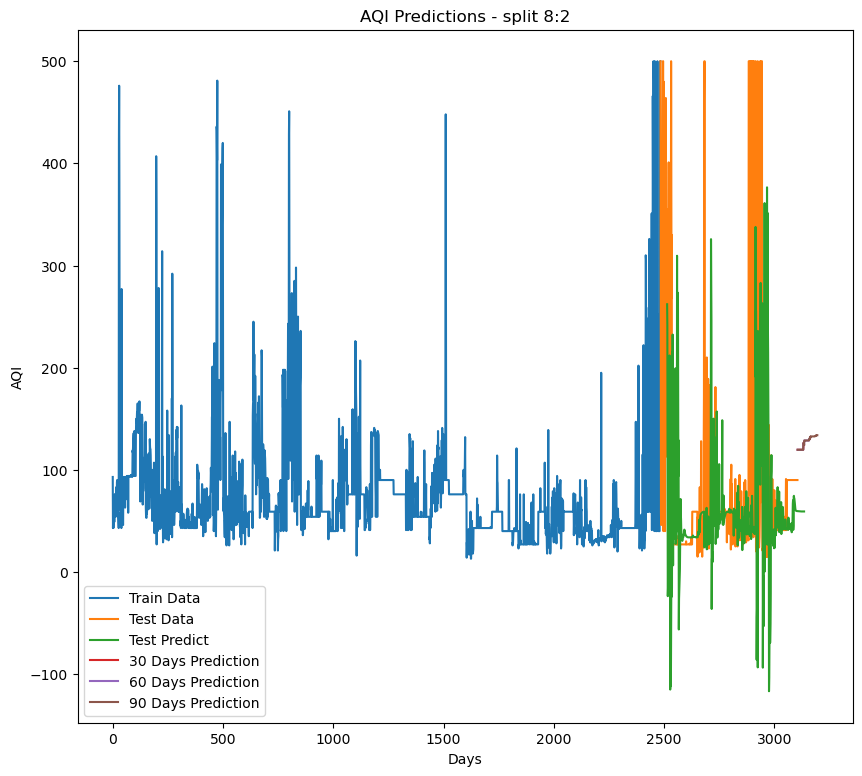

[[0.16427105]
 [0.06160164]
 [0.0862423 ]
 ...
 [0.06160164]
 [0.08829569]
 [0.09856263]]
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0151 - mae: 0.0681 - val_loss: 0.0984 - val_mae: 0.1653
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0135 - mae: 0.0641 - val_loss: 0.1001 - val_mae: 0.1676
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - mae: 0.0742 - val_loss: 0.0686 - val_mae: 0.1427
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - mae: 0.0640 - val_loss: 0.0733 - val_mae: 0.1390
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0138 - mae: 0.0626 - val_loss: 0.0831 - val_mae: 0.1517
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0155 - mae: 0.0671 - val_loss: 0.0681 - val_mae: 0.1384
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0141 - mae: 0.0660 - val_loss: 0.0822 - val_mae: 0.1575
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0141 - mae: 0.0636 - val_loss: 0.1082

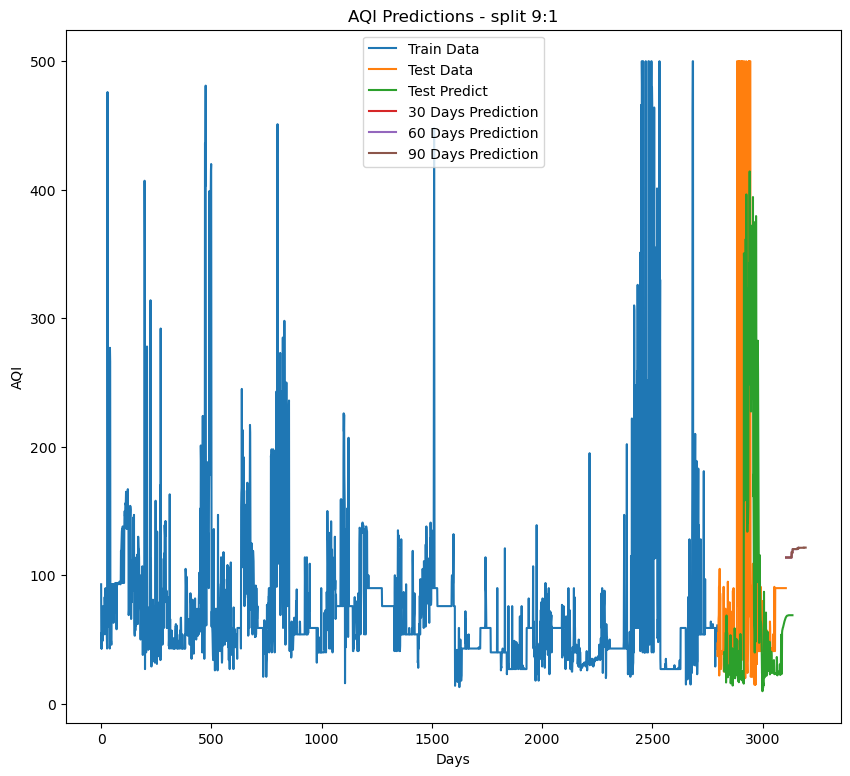

In [5]:
train_sizes = [0.7, 0.8, 0.9]
for train_size_ratio in train_sizes:
    # Split data into training and testing sets
    train_size = int(len(X) * train_size_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    # Reshape data to match model input
    X_train = np.reshape(X_train, (X_train.shape[0], timesteps, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))
    print(y_train)
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Inverse transform the predictions and true values
    y_pred_inverse = scaler.inverse_transform(y_pred[:, -1, 0].reshape(-1, 1))
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')   
       # Calculate future predictions
    df1 = df.reset_index()['AQI']
    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
    future_30_days = predict_future(model, df1, timesteps, 30, scaler)
    future_60_days = predict_future(model, df1, timesteps, 60, scaler)
    future_90_days = predict_future(model, df1, timesteps, 90, scaler)
    # Plot the results
    plt.figure(figsize=(10, 9))

    # Plot train data
    plt.plot(y_train_inverse, label='Train Data')

    # Plot test data
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inverse, label='Test Data')

    # Plot test predictions
    plt.plot(np.arange(len(y_train) + timesteps, len(y_train) + timesteps + len(y_pred_inverse)), y_pred_inverse, label='Test Predict')
    plt.plot(np.arange(len(X), len(X) + 30), future_30_days, label="30 Days Prediction")
    plt.plot(np.arange(len(X), len(X) + 60), future_60_days, label="60 Days Prediction")
    plt.plot(np.arange(len(X), len(X) + 90), future_90_days, label="90 Days Prediction")

    # Add labels and legend
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.title(f'AQI Predictions - split {custom_round(train_size_ratio * 10)}:{custom_round((1-train_size_ratio) * 10)}')
    plt.legend()
    plt.show()